In [5]:
import torch 
import gpytorch
import numpy as np
import sys 
import os
sys.path.append(os.path.abspath('..'))
from pv_plot import plot_train_test_split, plot_grid
from data.utils import *
from data import PVDataGenerator, PVDataLoader
from models import MultitaskGPModel
from kernels import Kernel
from likelihoods.beta import MultitaskBetaLikelihood
from gpytorch.means import ZeroMean, ConstantMean

In [145]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 10
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
N_DAYS_TRAIN = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 10
RADIUS = 0.35
CIRCLE_COORDS = (55, -1.5)
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [171]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=CIRCLE_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='circle',
                    drop_nan=True)

X, y = generator.get_time_series()
num_latent = 4
num_tasks = y.shape[1]

==> Loading data
==> Loaded data in: 0 m : 7 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



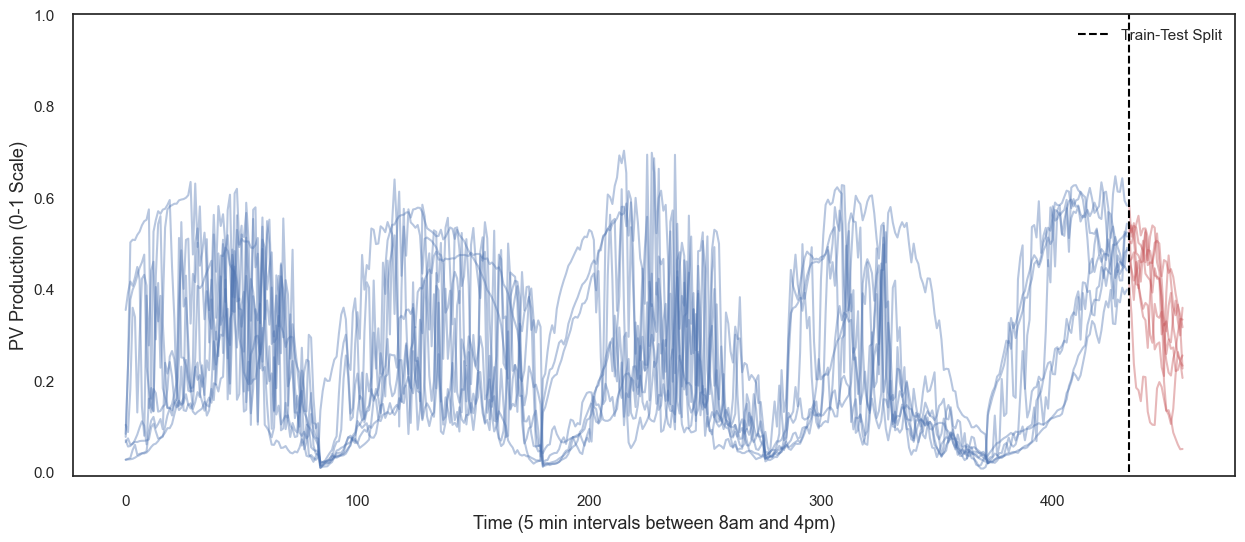

In [172]:
x_train, y_train, x_test, y_test = train_test_split(X, y, hour=14,n_hours=N_HOURS_PRED)
plot_train_test_split(y_train, y_test)

In [173]:
mean = ConstantMean(batch_shape=torch.Size([num_latent]))
likelihood = MultitaskBetaLikelihood(num_tasks=num_tasks, scale=60)

kernel_module = Kernel(num_latent=num_latent)
matern_base = kernel_module.get_matern()
matern_quasi = kernel_module.get_matern()
periodic1 = kernel_module.get_periodic()

quasi_periodic = kernel_module.get_quasi_periodic(matern_base, matern_quasi, periodic1)


In [174]:
model = MultitaskGPModel(x_train=x_train,
                        y_train=y_train,
                        likelihood=likelihood,
                        mean_module=mean,
                        covar_module=quasi_periodic,
                        num_latents=num_latent)

In [175]:
model.fit(n_iter=500, lr=0.1, verbose=True)

Iter 50/500 - Loss: -5.627840518951416
Iter 100/500 - Loss: -6.835472106933594
Iter 150/500 - Loss: -7.372501373291016
Iter 200/500 - Loss: -7.6755781173706055
Iter 250/500 - Loss: -7.881321907043457
Iter 300/500 - Loss: -8.029520988464355
Iter 350/500 - Loss: -8.135510444641113
Iter 400/500 - Loss: -8.229499816894531
Iter 450/500 - Loss: -8.299768447875977
Iter 500/500 - Loss: -8.351049423217773


In [176]:
def predict(model, x):
    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.num_likelihood_samples(30):
        dist = model.likelihood(model(x))
        mode = model.likelihood.mode().mean(axis=0)
        mean = dist.mean.mean(axis=0)
        samples = dist.sample(sample_shape=torch.Size([30]))
        median = samples.median(axis=0).values.mean(axis=0)
        lower, upper = np.percentile(samples, [2.5, 97.5], axis=0)
        lower = lower.mean(axis=0)
        upper = upper.mean(axis=0)
    return median, lower, upper, mean, mode, dist


In [184]:
median_tr, lower_tr, upper_tr, mean_tr, mode_tr, dist_tr = predict(model, x_train)
median_te, lower_te, upper_te, mean_te, mode_te, dist_te = predict(model, x_test)

In [188]:
for i in range(y_test.shape[1]):
    lower, upper = lower_te[:, i], upper_te[:, i]
    y = y_test[:, i].numpy()
    inside = ((y >= lower) & (y <= upper)).sum()
    print(f'Percentage inside 95% CI: {(inside / y_test.shape[0])*100:.2f}%')

Percentage inside 95% CI: 62.50%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 75.00%
Percentage inside 95% CI: 83.33%
Percentage inside 95% CI: 66.67%
Percentage inside 95% CI: 58.33%


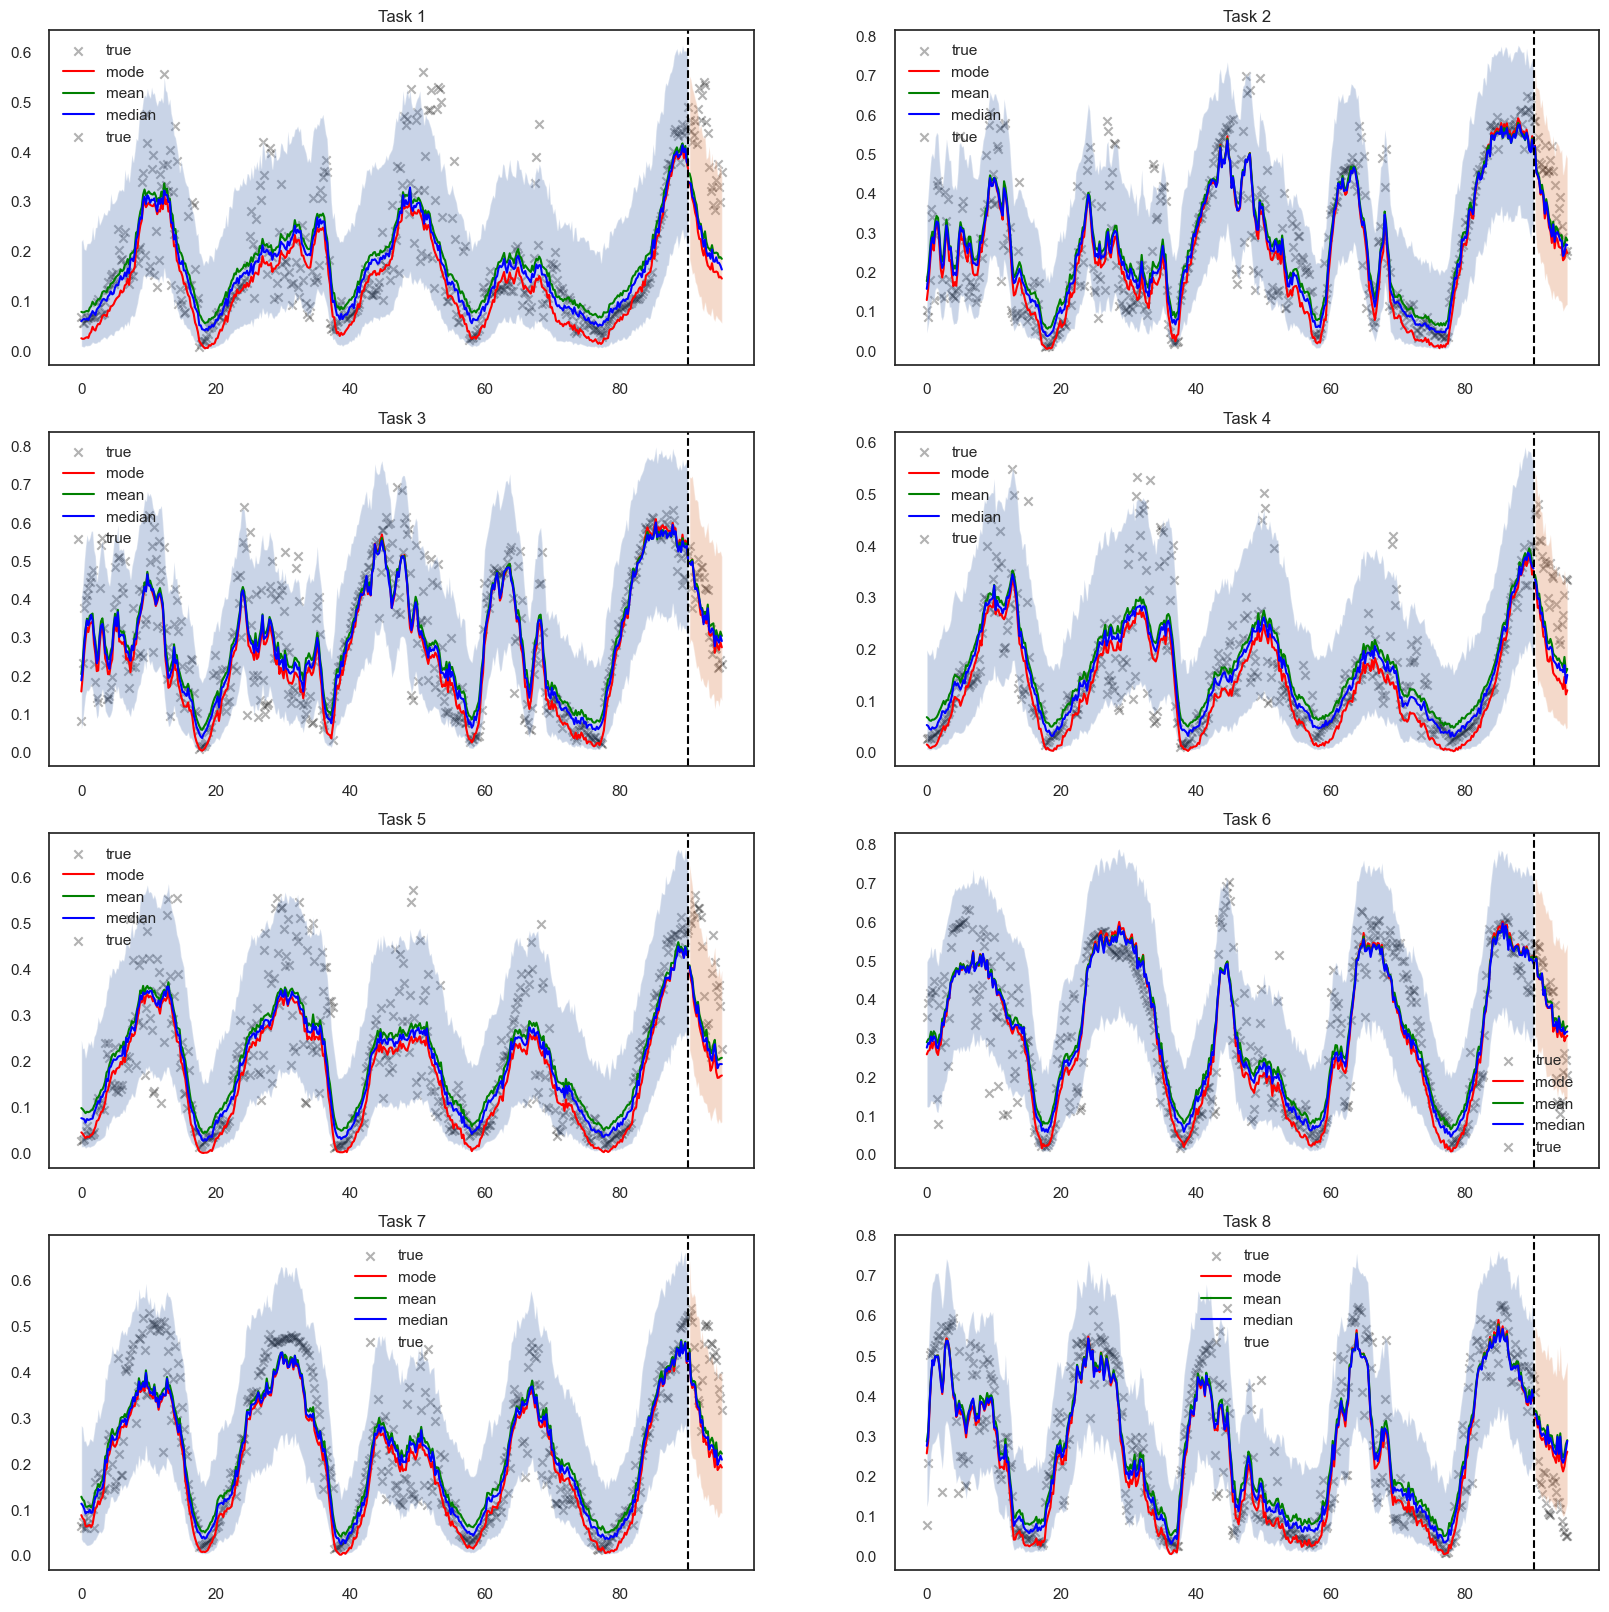

In [178]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(y.size(-1) // 2, 2, figsize=(20, 20))
ax = ax.flatten()

for i in range(y.size(-1)):
    ax[i].scatter(x_train, y_train[:,i], label='true', marker='x', color='black', alpha=0.3)
    ax[i].plot(x_train, mode_tr[:,i], label='mode', color='red')
    ax[i].plot(x_train, mean_tr[:,i], label='mean', color='green')
    ax[i].plot(x_train, median_tr[:,i], label='median', color='blue')
    ax[i].fill_between(x_train, lower_tr[:,i], upper_tr[:,i], alpha=0.3)
    
    ax[i].scatter(x_test, y_test[:,i], label='true', marker='x', color='black', alpha=0.3)
    ax[i].plot(x_test, mode_te[:,i],color='red')
    ax[i].plot(x_test, mean_te[:,i], color='green')
    ax[i].plot(x_test, median_te[:,i], color='blue')
    ax[i].fill_between(x_test, lower_te[:,i], upper_te[:,i], alpha=0.3)
    
    # plot vertical lines for train/test split
    ax[i].axvline(x_train.max(), color='black', linestyle='--')

    ax[i].legend()
    ax[i].set_title(f'Task {i+1}')

In [179]:
from gpytorch.metrics import negative_log_predictive_density as nlpd

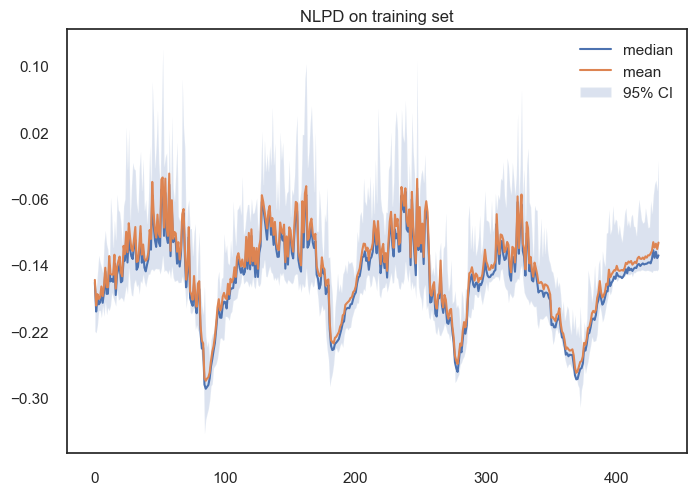

In [180]:
nlpd_tr = nlpd(dist_tr, y_train).detach().numpy()
nlpd_te = nlpd(dist_te, y_test).detach().numpy()

median_nlpd_tr = np.median(nlpd_tr, axis=0)
median_nlpd_te = np.median(nlpd_te, axis=0)
mean_nlpd_tr = np.mean(nlpd_tr, axis=0)
mean_nlpd_te = np.mean(nlpd_te, axis=0)

mean_median_nlpd_tr = np.mean(median_nlpd_tr, axis=1)
mean_median_nlpd_te = np.mean(median_nlpd_te, axis=1)
mean_mean_nlpd_tr = np.mean(mean_nlpd_tr, axis=1)
mean_mean_nlpd_te = np.mean(mean_nlpd_te, axis=1)

lower_tr, upper_tr = np.percentile(nlpd_tr, [2.5, 97.5], axis=0)
lower_te, upper_te = np.percentile(nlpd_te, [2.5, 97.5], axis=0)

lower_tr, upper_tr = np.median(lower_tr, axis=1), np.median(upper_tr, axis=1)
lower_te, upper_te = np.median(lower_te, axis=1), np.median(upper_te, axis=1)

plt.plot(mean_median_nlpd_tr, label='median')
plt.plot(mean_mean_nlpd_tr, label='mean')
plt.fill_between(np.arange(len(mean_median_nlpd_tr)), lower_tr, upper_tr, alpha=0.2, label='95% CI')

plt.legend()
plt.title('NLPD on training set')
plt.yticks(np.linspace(-0.3, 0.1, 6))
plt.show()

Text(0, 0.5, 'NLPD')

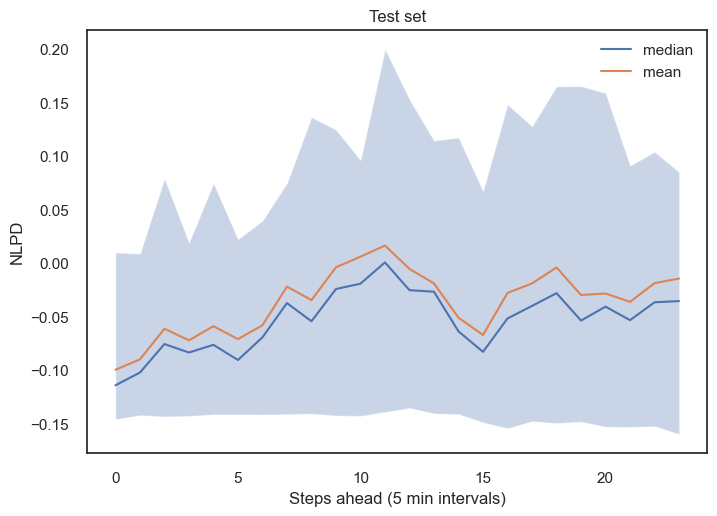

In [181]:
plt.plot(mean_median_nlpd_te, label='median')
plt.plot(mean_mean_nlpd_te, label='mean')
plt.fill_between(range(len(mean_median_nlpd_te)), lower_te, upper_te, alpha=0.3)

plt.legend()
plt.title('Test set')
plt.xlabel('Steps ahead (5 min intervals)')
plt.ylabel('NLPD')

In [182]:
model.likelihood.scale

tensor([[17.8893, 15.5340, 15.1527, 18.3359, 17.1904, 15.5682, 20.4905, 16.6460]],
       grad_fn=<SoftplusBackward0>)